In [1]:
import cv2
import pickle
from PIL import Image
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [2]:
import numpy as np

import torch
import torch.nn as nn

import math


In [3]:
data_transforms = {
	'train': transforms.Compose([
		transforms.Resize((256, 256)),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
	'val': transforms.Compose([
		transforms.Resize((256, 256)),
		transforms.ToTensor(),
# 		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
}

In [4]:
atlas_tex = data_transforms["train"](Image.open("./atlas_texture_1.jpg"))
atlas_tex_batch = torch.stack([atlas_tex, atlas_tex])
atlas_tex_batch.shape

torch.Size([2, 3, 256, 256])

In [5]:
np.max(atlas_tex_batch.numpy())

2.3611329

In [6]:
np.min(atlas_tex_batch.numpy())

-2.117904

In [7]:
target_dense = np.load("./dense.npy")
target_dense = np.moveaxis(target_dense, 0, -1)
target_dense = cv2.resize(target_dense, dsize=(256, 256), interpolation = cv2.INTER_NEAREST)

target_dense1 = np.load("./dense1.npy")
target_dense1 = np.moveaxis(target_dense1, 0, -1)
target_dense1 = cv2.resize(target_dense1, dsize=(256, 256), interpolation = cv2.INTER_NEAREST)

target_dense = torch.from_numpy(target_dense)
target_dense1 = torch.from_numpy(target_dense1)
target_dense_batch = torch.stack([target_dense, target_dense1])
# target_dense_batch = target_dense_batch.permute(0, 3, 1, 2)
target_dense_batch.shape

torch.Size([2, 256, 256, 3])

In [152]:
class FeatureRender(nn.Module):
    def __init__(self):
        super(FeatureRender, self).__init__()

    def forward(self, feature, dense_pose):
        atlas_feature = self._unfold_texture(feature)		# dimension(batch_size, channel, 24, height, width)
        mapped_feature = self._map_texture(atlas_feature, dense_pose)
        return mapped_feature


    # unfolding the atlas feature textures to 24 channels
    def _unfold_texture(self, feature):
        self.bs, self.c, self.h, self.w = feature.shape
        self.height_fraction = math.floor(self.h/4)
        self.width_fraction = math.floor(self.w/6)

        unfolded_feature = feature.unfold(2, self.height_fraction, self.height_fraction).unfold(3, self.width_fraction, self.width_fraction)
        unfolded_feature = unfolded_feature.reshape(self.bs, self.c, 24, self.height_fraction, self.width_fraction)

        return unfolded_feature


    # function to transfer map the atlas texture from uv space of densepose to image pixels of human image	
    def _map_texture(self, texture, dense_pose):
        _, self.dense_h, self.dense_w, self.dense_c = dense_pose.shape
                
        # scattering the uv values to 25 parts based on the class information present in channel 1
        dense_scatter_zeros = torch.zeros(25, self.bs, self.dense_h, self.dense_w)
        dense_scatter_U = dense_scatter_zeros.scatter_(0, dense_pose[:,:,:,0].unsqueeze(0).long(), dense_pose[:,:,:,1].unsqueeze(0).float())
        dense_scatter_V = dense_scatter_zeros.scatter_(0, dense_pose[:,:,:,0].unsqueeze(0).long(), dense_pose[:,:,:,2].unsqueeze(0).float())

        dense_U = dense_pose[:,:,:,1].unsqueeze(0)
        dense_U = dense_U.repeat(25, 1, 1, 1)

        dense_V = dense_pose[:,:,:,2].unsqueeze(0)
        dense_V = dense_V.repeat(25, 1, 1, 1)

        dense_scatter_U[dense_scatter_U != 0] = 1
        dense_scatter_V[dense_scatter_V != 0] = 1
        
        # calculating dense_mask
        dense_class_mask = dense_scatter_U[1:,:,:,:].permute(1,0,2,3).unsqueeze(1).repeat(1,self.c,1,1,1)
        print(dense_class_mask.shape)
        
        dense_scatter_U = dense_scatter_U * dense_U
        dense_scatter_V = dense_scatter_V * dense_V

        dense_scatter_U = dense_scatter_U.permute(1, 0, 2, 3)
        dense_scatter_V = dense_scatter_V.permute(1, 0, 2, 3)

        # changing the range of values from uv to height and width of texture 
        dense_scatter_U = dense_scatter_U * (self.height_fraction-1)/255.
        dense_scatter_V = (255-dense_scatter_V)*(self.width_fraction-1)/255.

        # repeating the texture co-ordinate values for all the channels of texture
        dense_scatter_U = dense_scatter_U.unsqueeze(2)
        dense_scatter_U = dense_scatter_U.repeat(1, 1, self.c, 1, 1)
        dense_scatter_V = dense_scatter_V.unsqueeze(2)
        dense_scatter_V = dense_scatter_V.repeat(1, 1, self.c, 1, 1)

        # considerting the last 24 body parts ignoring the first part, which is for background
        # long conversion is needed for indexing
        dense_scatter_U = dense_scatter_U[:,1:,:,:,:].long()
        dense_scatter_V = dense_scatter_V[:,1:,:,:,:].long()

        # permuting the dimension of texture to match with the mapped desepose dimension
        texture = texture.permute(0, 2, 1, 3, 4)


        # retrieving the texture pixel values based on the co-ordinates calculated from uv map
        expanded_dim = self.bs * 24 * self.c
        expanded_dense_spatial_dim = self.dense_h * self.dense_w
        painted_texture = texture.reshape(expanded_dim, self.height_fraction, self.width_fraction) \
                            [torch.arange(expanded_dim).repeat_interleave(expanded_dense_spatial_dim), \
                            dense_scatter_U.reshape(expanded_dim * expanded_dense_spatial_dim), \
                            dense_scatter_V.reshape(expanded_dim * expanded_dense_spatial_dim)]

        # rearranging the dimensions and geeting the sum all the body parts, to get the full texture on the densepose
        painted_texture = painted_texture.reshape(self.bs, 24, self.c, self.dense_h, self.dense_w)
        painted_texture = painted_texture.permute(0, 2, 1, 3, 4)
        print(painted_texture.shape)
        print(dense_class_mask.shape)
        painted_texture = painted_texture * dense_class_mask
        painted_texture_summed = torch.sum(painted_texture, 2)
        return painted_texture, painted_texture_summed

In [153]:
render = FeatureRender()

In [154]:
painted_texture, painted_texture_summed = render(atlas_tex_batch, target_dense_batch)

torch.Size([2, 3, 24, 256, 256])
torch.Size([2, 3, 24, 256, 256])
torch.Size([2, 3, 24, 256, 256])


In [141]:
painted_texture.shape

torch.Size([2, 3, 24, 256, 256])

In [142]:
np.max(painted_texture_summed.numpy())

-38.72279

In [155]:
paint = painted_texture_summed[0].permute(1,2,0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

In [156]:
np.max(painted_texture_summed[0].numpy())

2.3611329

In [33]:
(paint[180:210,90:110,0])

array([[-4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09],
       [-4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09],
       [-4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.0531159e-09,
        -4.0531159e-09, -4.0531159e-09, -4.0531159e-09, -4.053

In [34]:
ex_img = hello[0].permute(1,2,0).numpy()* [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
# ex_img = hello[0].permute(1,2,0).numpy()
ex_img = np.uint8(ex_img * 255 * 2)

NameError: name 'hello' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


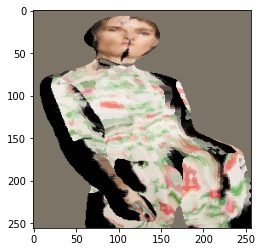

In [157]:
plt.imshow(paint)

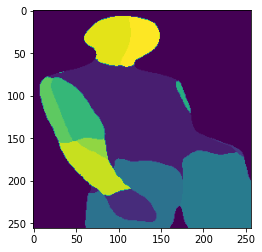

In [284]:
plt.imshow(target_dense_batch[0,:,:,0].numpy())

In [285]:
# unfolding the atlas feature textures to 24 channels
def _unfold_texture(feature):
    bs, c, h, w = feature.shape
    height_fraction = math.floor(h/4)
    width_fraction = math.floor(w/6)

    unfolded_feature = feature.unfold(2, height_fraction, height_fraction).unfold(3, width_fraction, width_fraction)
    unfolded_feature = unfolded_feature.reshape(bs, c, 24, height_fraction, width_fraction)

    return unfolded_feature

In [286]:
texture = _unfold_texture(atlas_tex_batch)

In [287]:
texture.shape

torch.Size([2, 3, 24, 64, 42])

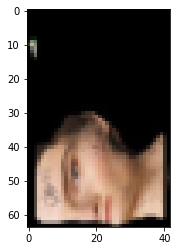

In [288]:
plt.imshow(texture[0][:,22,:,:].permute(1, 2, 0).numpy())

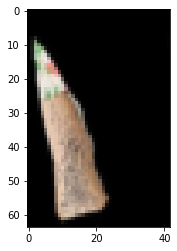

In [289]:
plt.imshow(texture[0][:,21,:,:].permute(1, 2, 0).numpy())

In [290]:
bs, c, h, w = atlas_tex_batch.shape

In [291]:
height_fraction = math.floor(h/4)
width_fraction = math.floor(w/6)

In [292]:
dense_pose = target_dense_batch

In [293]:
_, dense_h, dense_w, dense_c = target_dense_batch.shape


In [294]:
dense_scatter_zeros = torch.zeros(25, bs, dense_h, dense_w)
dense_scatter_U = dense_scatter_zeros.scatter_(0, dense_pose[:,:,:,0].unsqueeze(0).long(), dense_pose[:,:,:,1].unsqueeze(0).float())
dense_scatter_V = dense_scatter_zeros.scatter_(0, dense_pose[:,:,:,0].unsqueeze(0).long(), dense_pose[:,:,:,2].unsqueeze(0).float())

In [295]:
dense_scatter_U.shape

torch.Size([25, 2, 256, 256])

In [296]:
dense_U = dense_pose[:,:,:,1].unsqueeze(0)
dense_U = dense_U.repeat(25, 1, 1, 1)

dense_V = dense_pose[:,:,:,2].unsqueeze(0)
dense_V = dense_V.repeat(25, 1, 1, 1)

dense_U.shape, dense_V.shape

(torch.Size([25, 2, 256, 256]), torch.Size([25, 2, 256, 256]))

In [297]:
dense_scatter_U[dense_scatter_U != 0] = 1
dense_scatter_V[dense_scatter_V != 0] = 1

In [298]:
dense_scatter_U = dense_scatter_U * dense_U
dense_scatter_V = dense_scatter_V * dense_V

dense_scatter_U = dense_scatter_U.permute(1, 0, 2, 3)
dense_scatter_V = dense_scatter_V.permute(1, 0, 2, 3)

dense_scatter_U.shape, dense_scatter_V.shape

(torch.Size([2, 25, 256, 256]), torch.Size([2, 25, 256, 256]))

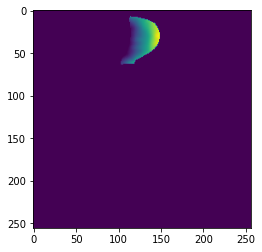

In [299]:
plt.imshow(dense_scatter_U[0][24].numpy())

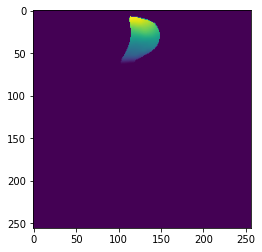

In [300]:
plt.imshow(dense_scatter_V[0][24].numpy())

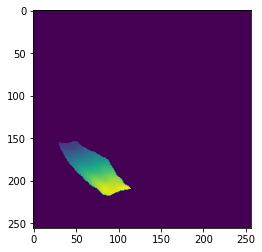

In [301]:
plt.imshow(dense_scatter_U[0][22].numpy())

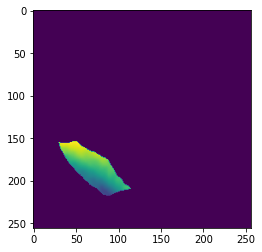

In [302]:
plt.imshow(dense_scatter_V[0][22].numpy())

In [303]:
dense_scatter_U.max()

tensor(255.)

In [304]:
np.unique(dense_scatter_U)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [305]:
width_fraction

42

In [306]:
dense_scatter_U = dense_scatter_U * (height_fraction-1)/255.
dense_scatter_V = (255-dense_scatter_V)*(width_fraction-1)/255.

In [307]:
dense_scatter_U.max()

tensor(63.)

In [308]:
dense_scatter_U = dense_scatter_U.unsqueeze(2)
dense_scatter_U = dense_scatter_U.repeat(1, 1, c, 1, 1)
dense_scatter_V = dense_scatter_V.unsqueeze(2)
dense_scatter_V = dense_scatter_V.repeat(1, 1, c, 1, 1)
dense_scatter_U.shape, dense_scatter_V.shape

(torch.Size([2, 25, 3, 256, 256]), torch.Size([2, 25, 3, 256, 256]))

In [309]:
dense_scatter_U = dense_scatter_U[:,1:,:,:,:].long()
dense_scatter_V = dense_scatter_V[:,1:,:,:,:].long()
dense_scatter_U.shape, dense_scatter_V.shape

(torch.Size([2, 24, 3, 256, 256]), torch.Size([2, 24, 3, 256, 256]))

In [310]:
texture = texture.permute(0, 2, 1, 3, 4)
texture.shape

torch.Size([2, 24, 3, 64, 42])

In [311]:
expanded_dim = bs * 24 * c
expanded_dense_spatial_dim = dense_h * dense_w
painted_texture = texture.reshape(expanded_dim, height_fraction, width_fraction) \
                    [torch.arange(expanded_dim).repeat_interleave(expanded_dense_spatial_dim), \
                    dense_scatter_U.reshape(expanded_dim * expanded_dense_spatial_dim), \
                    dense_scatter_V.reshape(expanded_dim * expanded_dense_spatial_dim)]

In [312]:
painted_texture = painted_texture.reshape(bs, 24, c, dense_h, dense_w)
painted_texture = painted_texture.permute(0, 2, 1, 3, 4)
painted_texture = torch.sum(painted_texture, 2)

In [342]:
np.min(painted_texture.numpy())

0.019607844

In [320]:
examp_texture = painted_texture[0].permute(1,2,0)
# examp_texture = np.array(examp_texture)/255
# examp_texture = examp_texture * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
# examp_texture = np.uint8(examp_texture * 255)

In [321]:
np.unique(examp_texture)

array([0.02352941, 0.02745098, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.0509804 , 0.05490196,
       0.05882353, 0.0627451 , 0.07058824, 0.07450981, 0.07843138,
       0.08235294, 0.08627451, 0.09019608, 0.09411765, 0.09803922,
       0.10196079, 0.10196079, 0.10588235, 0.10588236, 0.10980392,
       0.10980393, 0.11372549, 0.1137255 , 0.11764706, 0.11764707,
       0.12156863, 0.12156864, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20000002, 0.20392157, 0.20392159,
       0.20784314, 0.20784315, 0.21176471, 0.21176472, 0.21568628,
       0.21568629, 0.21960786, 0.22352941, 0.22352943, 0.22745098,
       0.227451  , 0.23137257, 0.23529413, 0.23921569, 0.2392157 ,
       0.24313727, 0.24705882, 0.24705884, 0.2509804 , 0.25490

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


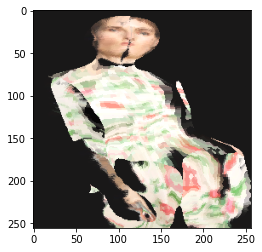

In [322]:
plt.imshow(examp_texture)

In [274]:
examp_texture.shape

(256, 256, 3)